In [ ]:
# def pole_zero_correct(waveform, use_pz=True):
#     """
#     Applies pole-zero correction to a given waveform.

#     Args:
#         raw waveform (np.array)
#     Returns:
#         waveform_pz (np.array): The PZ-corrected full waveform.
#         waveform_tail_corrected (np.array): The PZ-corrected tail portion of the waveform.
#     """
#     waveform = np.asarray(waveform, dtype=float)
#     if not use_pz:
#         return waveform, waveform

#     # Identify the peak value
#     # peak_idx = peak_after_max_slope(waveform)
#     # peak_value = waveform[peak_idx]
#     peak_value = np.max(waveform)
#     # Isolate the tail (starting at 98% of the peak)
#     t98 = np.where(waveform >= 0.98 * peak_value)[0][0] 
#     # Generate the time index necessary for the fit 
#     time_index = np.arange(0, len(waveform))
#     tail_time = np.arange(0, time_index[-1] - t98 + 1)
#     tail_values = waveform[t98:]

#     # initial guess
#     p0 = [tail_values[0], 300.0, tail_values[0] * 0.1, 1500.0]
#     # Fit the parameters (with error handling)
#     try:
#         # Fit the decay model to the raw tail values
#         params, params_cov = curve_fit(
#             exponential, 
#             tail_time, 
#             tail_values,
#             p0=p0, 
#             maxfev=20000)
#     except (RuntimeError, ValueError):
#         # If the curve_fit fails to converge (e.g., due to noise or pile-up), 
#         # return a copy of the original waveform to prevent the pipeline from crashing.
#         return np.copy(waveform), waveform[t98:]

#     # Calculate the correction factor and apply it
#     f_decay = exponential(tail_time, *params)   
#     # Estimate the initial value of the tail (f_t0) from the first few samples near t98
#     f_t0 = np.mean(waveform[t98:t98+5])
#     # Calculate the inverse correction factor (f_pz). 
#     # This factor, when multiplied by the tail, flattens the exponential decay.    
#     eps = 1e-12
#     f_pz = f_t0 / (f_decay + eps)
  
#     # Apply the correction
#     waveform_tail_corrected = tail_values * f_pz
#     # Create the final corrected waveform
#     waveform_pz = np.copy(waveform)
#     waveform_pz[t98:] = waveform_tail_corrected
    
#     return waveform_pz, waveform_tail_corrected

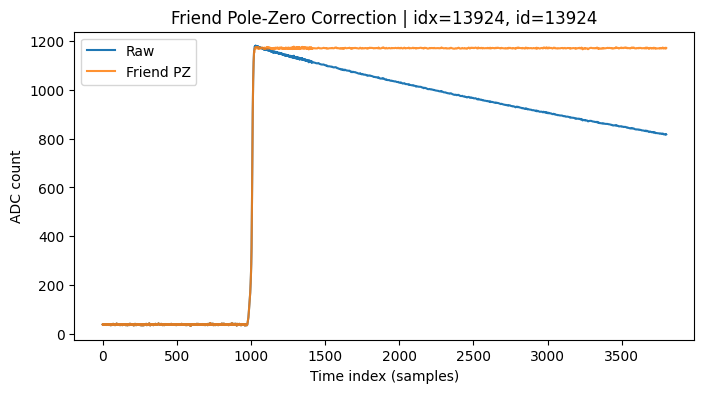

ID: 13924
Computed LQ80 (raw area - friendPZ area): -522353.3379409956


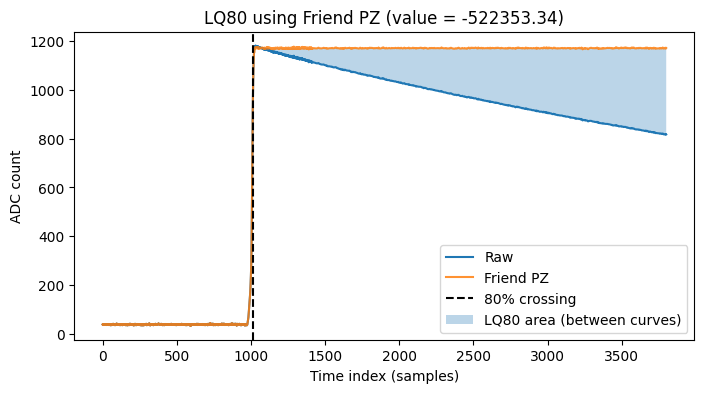

In [1]:
import h5py
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

train_file = "../data/old/MJD_Train_0.hdf5"

# ----------------------------
# Helper: baseline estimate
# ----------------------------
def estimate_baseline(y, n_samples=200):
    y0 = np.asarray(y, dtype=float)[:n_samples]
    return float(np.mean(y0)), float(np.std(y0))

# ----------------------------
# Friend's decay model + PZ correction
# IMPORTANT: her function uses `exponential`, so define it.
# ----------------------------
def exponential(t, a, tau1, b, tau2):
    return a * np.exp(-t / tau1) + b * np.exp(-t / tau2)

def pole_zero_correct(waveform, use_pz=True):
    """
    Applies pole-zero correction to a given waveform.

    Args:
        waveform (np.array)
    Returns:
        waveform_pz (np.array): The PZ-corrected full waveform.
        waveform_tail_corrected (np.array): The PZ-corrected tail portion of the waveform.
    """
    waveform = np.asarray(waveform, dtype=float)
    if not use_pz:
        return waveform, waveform

    peak_value = np.max(waveform)
    if (not np.isfinite(peak_value)) or peak_value <= 0:
        return np.copy(waveform), np.copy(waveform)

    # Start tail at 98% of peak
    idx98 = np.where(waveform >= 0.98 * peak_value)[0]
    if len(idx98) == 0:
        return np.copy(waveform), np.copy(waveform)
    t98 = int(idx98[0])

    time_index = np.arange(len(waveform), dtype=float)
    tail_time = np.arange(0, len(waveform) - t98, dtype=float)
    tail_values = waveform[t98:]

    p0 = [tail_values[0], 300.0, tail_values[0] * 0.1, 1500.0]

    try:
        params, _ = curve_fit(
            exponential,
            tail_time,
            tail_values,
            p0=p0,
            maxfev=20000
        )
    except (RuntimeError, ValueError):
        return np.copy(waveform), np.copy(waveform[t98:])

    f_decay = exponential(tail_time, *params)

    # initial tail level
    f_t0 = np.mean(waveform[t98:t98 + 5]) if (t98 + 5) <= len(waveform) else waveform[t98]

    eps = 1e-12
    f_pz = f_t0 / (f_decay + eps)

    waveform_tail_corrected = tail_values * f_pz
    waveform_pz = np.copy(waveform)
    waveform_pz[t98:] = waveform_tail_corrected

    return waveform_pz, waveform_tail_corrected

# ----------------------------
# LQ80 using YOUR definition, but using FRIEND'S corrected waveform
# (area raw - area corrected from the 80% crossing index)
# ----------------------------
def compute_LQ80_with_friend_pz(waveform):
    y = np.asarray(waveform, dtype=float)
    y_pz, _ = pole_zero_correct(y, use_pz=True)

    baseline, _ = estimate_baseline(y)
    peak_val = float(np.max(y))
    target = baseline + 0.80 * (peak_val - baseline)

    idx = np.where(y >= target)[0]
    if len(idx) == 0:
        return np.nan, y_pz, None

    i80 = int(idx[0])
    t = np.arange(len(y), dtype=float)

    area_raw = float(np.trapezoid(y[i80:], t[i80:]))
    area_corr = float(np.trapezoid(y_pz[i80:], t[i80:]))

    return area_raw - area_corr, y_pz, i80

# ----------------------------
# Load one waveform and run everything
# ----------------------------
with h5py.File(train_file, "r") as f:
    raw_waveforms = np.array(f["raw_waveform"])
    ids = np.array(f["id"])

n_events, n_samples = raw_waveforms.shape
time_index = np.arange(n_samples)

random_index = np.random.randint(0, n_events)
y = raw_waveforms[random_index]
event_id = ids[random_index]

# Friend PZ
y_friend_pz, y_friend_tail = pole_zero_correct(y, use_pz=True)

# Plot raw vs friend PZ
fig, ax = plt.subplots(figsize=(8, 4))
ax.plot(time_index, y, label="Raw")
ax.plot(time_index, y_friend_pz, label="Friend PZ", alpha=0.85)
ax.set_title(f"Friend Pole-Zero Correction | idx={random_index}, id={event_id}")
ax.set_xlabel("Time index (samples)")
ax.set_ylabel("ADC count")
ax.legend()
plt.show()

# LQ80 (your method) using friend PZ
lq80_value, y_pz_for_lq80, i80 = compute_LQ80_with_friend_pz(y)

print("ID:", event_id)
print("Computed LQ80 (raw area - friendPZ area):", lq80_value)

# LQ80 visualization
if i80 is not None and np.isfinite(lq80_value):
    baseline, _ = estimate_baseline(y)
    peak = np.max(y)
    target = baseline + 0.80 * (peak - baseline)

    fig, ax = plt.subplots(figsize=(8, 4))
    ax.plot(time_index, y, label="Raw", linewidth=1.5)
    ax.plot(time_index, y_pz_for_lq80, label="Friend PZ", linewidth=1.5, alpha=0.85)

    ax.axvline(i80, color="k", linestyle="--", label="80% crossing")

    # Shade between raw and corrected after i80 (absolute difference)
    ax.fill_between(
        time_index[i80:],
        y[i80:],
        y_pz_for_lq80[i80:],
        alpha=0.3,
        label="LQ80 area (between curves)"
    )

    ax.set_title(f"LQ80 using Friend PZ (value = {lq80_value:.2f})")
    ax.set_xlabel("Time index (samples)")
    ax.set_ylabel("ADC count")
    ax.legend()
    plt.show()
else:
    print("Could not compute i80 or LQ80 for this waveform (no 80% crossing or invalid value).")
